Fig. 2: Pancres main
----
Apply CellRank to the pancreas data example to show its main features in action. 

# Preliminaries

## Dependecy notebooks

Note: We use MAGIC imputed data and the Palantir pseudotime here which have been computed in the `fig_5_benchmarking/palantir` directory. Palantir's pseudotime is available in the `.obs` attribute of our pancreas example dataset. MAGIC imputed data is available on Figshare in the CellRank collection and has to be imported additionally. 

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.0.0-rc.12 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.1 numba==0.51.0 scipy==1.5.2 pandas==1.1.1 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.1 seaborn==0.10.1


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [3]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [4]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [5]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "pancreas", separate_dirs=True)
except ImportError:
    c = None
    
use_caching = c is not None
c

Cache(root=/Users/marius/Projects/cellrank_reproducibility/cache/pancreas, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [6]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Do we want to write figures?

In [7]:
save_figure = True

If there are other global parameters for this analysis, put them here as well. 

## Load the data

Load the AnnData object from the CellRank software package. 

In [8]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad" )
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

Additionally, load the MAGIC imputed data which we will need later on for gene trend plotting. 

In [9]:
magic_imputed_data = pd.read_csv(DATA_DIR / "pancreas" / "magic_imputed_data.csv", index_col=0)

# Compute velocities using scVelo

## Pre-process the data

We'll process the data in .raw a bit differently becasue we need more genes for trend plotting. 

### Raw data (for plotting)

We will use this object for gene trend plotting further down. 

In [10]:
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=10)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes, but don't filter them out
sc.pp.highly_variable_genes(adata_raw)
print(f"This detected {np.sum(adata_raw.var['highly_variable'])} highly variable genes. ")
adata.raw = adata_raw

filtered out 15011 genes that are detected in less than 10 cells
Normalized count data: X, spliced, unspliced.
extracting highly variable genes
    finished (0:00:00)
This detected 1480 highly variable genes. 


Add the MAGIC imputed data to the raw AnnData object, making sure that the order of cells and genes is correct. 

In [27]:
assert(adata_raw.shape == magic_imputed_data.shape), "Shape mismatch between AnnData and MAGIC imputed data"
adata_raw.layers['magic_imputed_data'] = magic_imputed_data[adata_raw.var_names].loc[adata_raw.obs_names]

### Data for velocity computation

In [28]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# compute pca, knn graph and scvelo's moments
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 58 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Visualize annotations and cell type composition

Often, we want to show UMAP plots with cluster annotation of marker genes here. This also serves as an example of figure saving. 

saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/suppl_figures_pancreas/suppl_fig_annotations/annotation_clusters.pdf


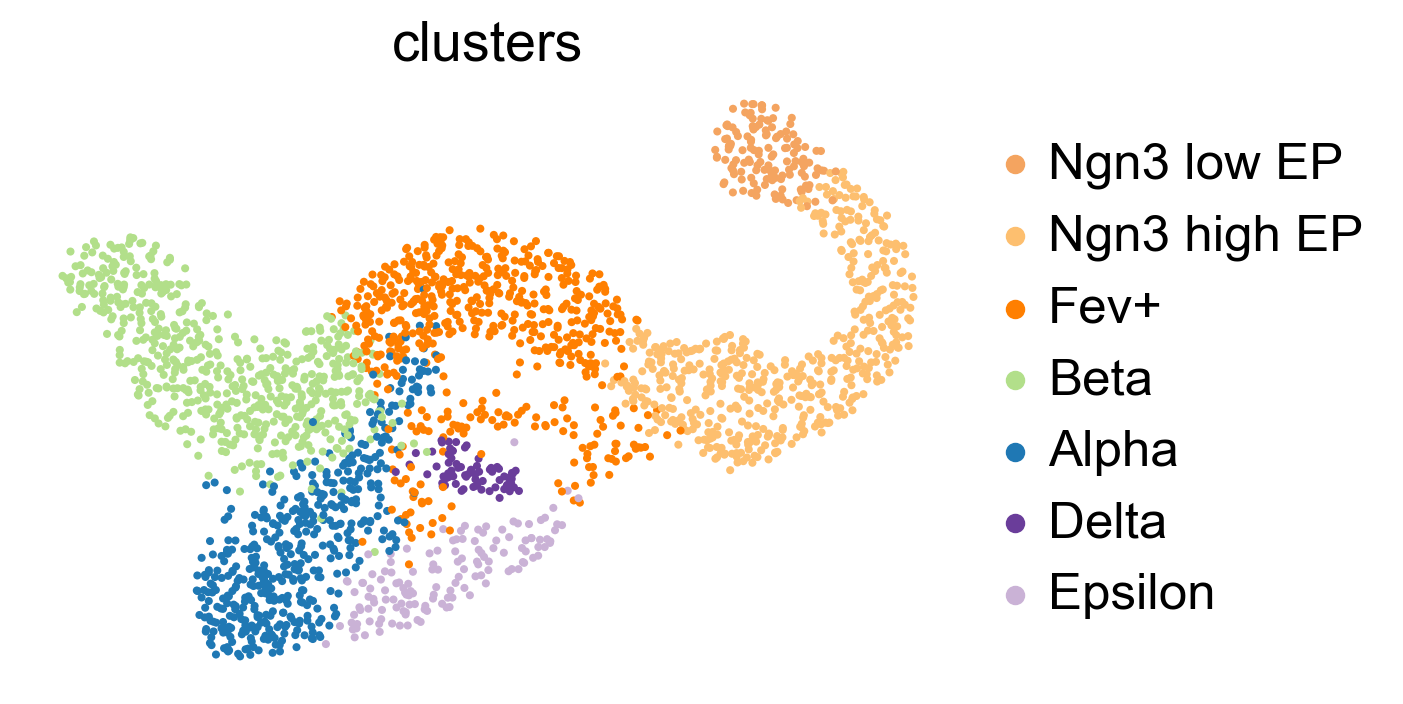

In [32]:
fig_kwargs = {'color': 'clusters', 'dpi': 100, 'legend_loc': 'right'}
if save_figure: fig_kwargs['save'] = "suppl_figures_pancreas/suppl_fig_annotations/annotation_clusters.pdf"
scv.pl.scatter(adata, **fig_kwargs)

saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/suppl_figures_pancreas/suppl_fig_annotations/annotations_clusters_fine.pdf


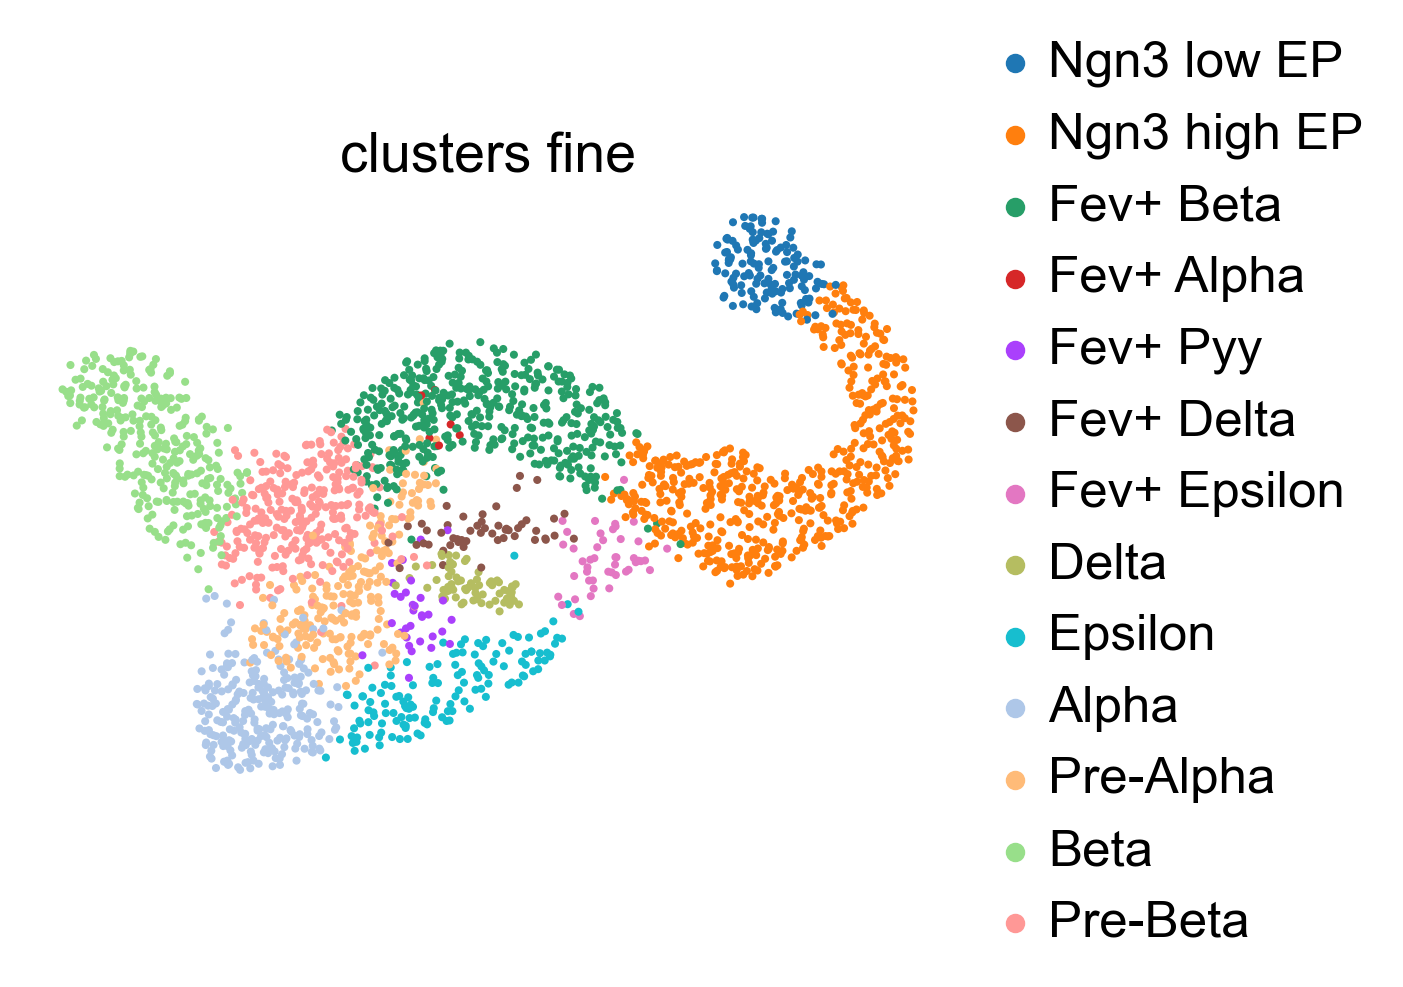

In [33]:
fig_kwargs = {'color': 'clusters_fine', 'dpi': 100, 'legend_loc': 'right'}
if save_figure: fig_kwargs['save'] = "suppl_figures_pancreas/suppl_fig_annotations/annotations_clusters_fine.pdf"
scv.pl.scatter(adata, **fig_kwargs)

Print cell type compotision

TypeError: can't multiply sequence by non-int of type 'float'

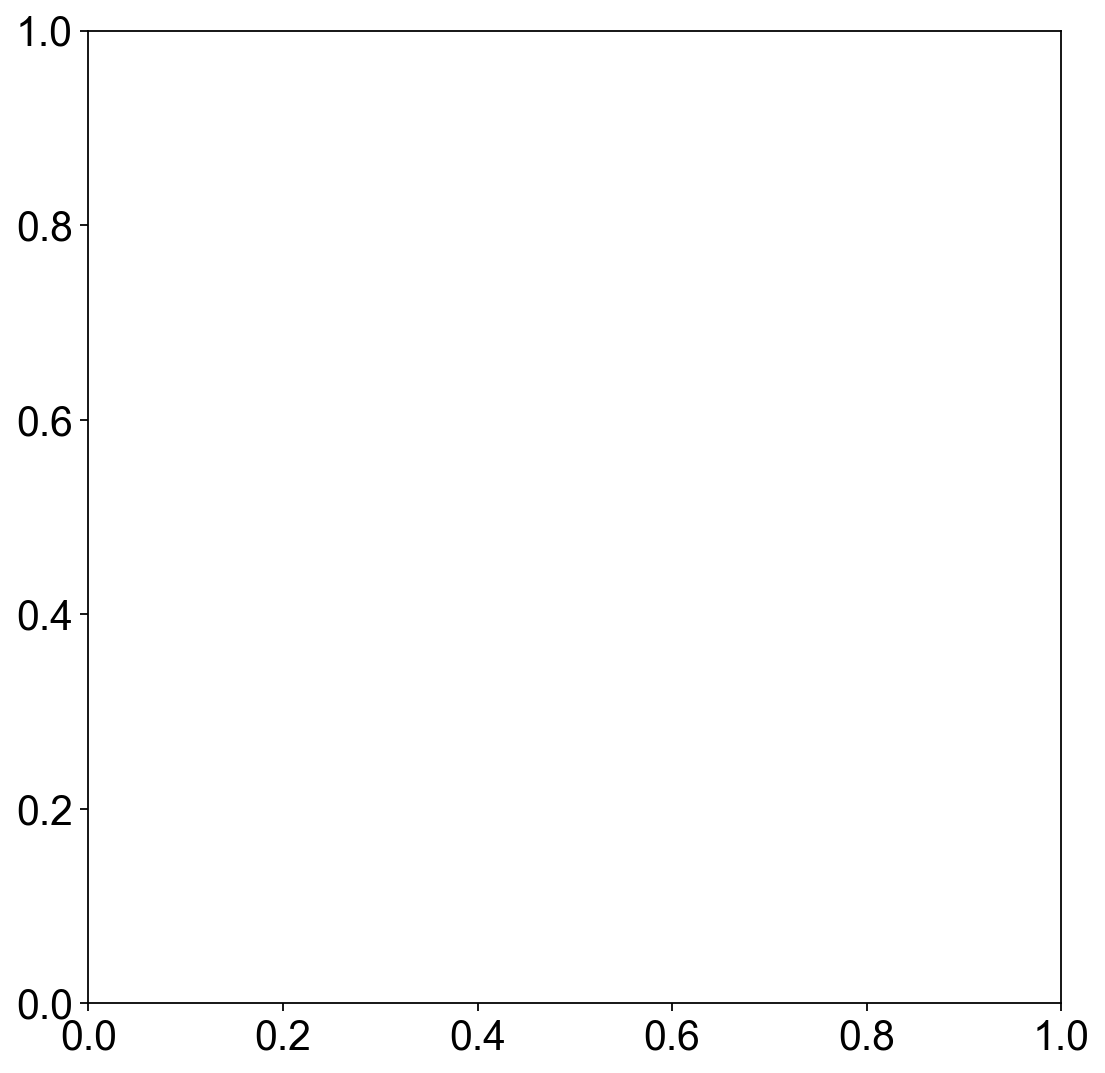

In [34]:
clusters = adata.obs['clusters'].cat.categories
explode = np.zeros(len(clusters))
mask = (clusters == 'Delta')
explode[mask] = 0.1

fig_kwargs = {'key': 'clusters', 'autopct': '%1.0f%%', 'explode': 'explode', 'figsize': (8, 8)}
if save_figure: fig_kwargs['save'] = "suppl_figures_pancreas/suppl_fig_annotations/clusters_composition.pdf"
cr.pl._utils.composition(adata, **fig_kwargs)

# print absolute number of Delta cells
print(f"There are {np.sum(adata.obs['clusters'] == 'Delta')} Delta cells in the data")

## Compute velocities using scVelo

In [13]:
# compute/load from cache the dyn. model params and compute velocities
if use_caching:
    c.tl.recover_dynamics(adata, fname='recover_dynamics', force=False)
else:
    scv.tl.recover_dynamics(adata)
    
scv.tl.velocity(adata, mode='dynamical')

No cache found in `recover_dynamics.pickle`, computing values.
recovering dynamics
    finished (0:07:53) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Project velocities onto the embedding

Often, we want to show velocities in the UMAP embedding here.

computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


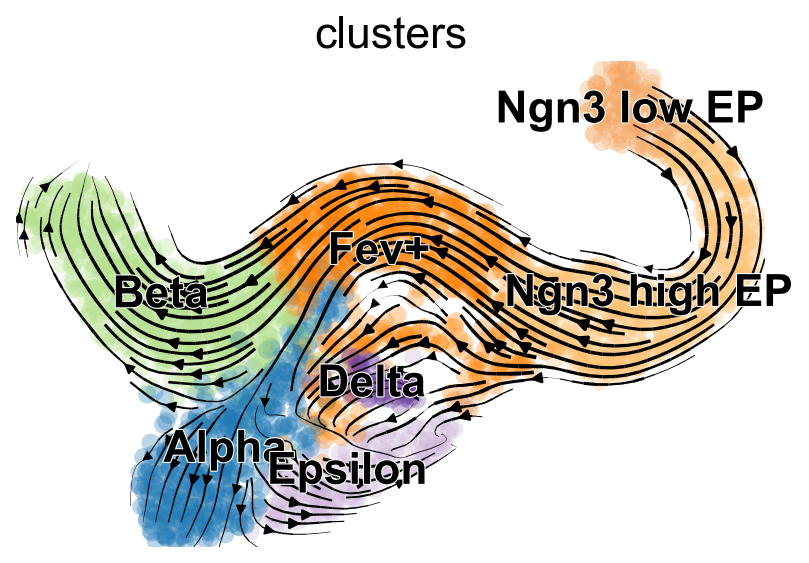

In [14]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata)

# Main analysis part 2

Typically, the second part of the analysis will involve CellRank. 

## Initialise kernel and estimator

This serves as an example of how to cach a transition matrix and of the default values we should be using. 

In [29]:
from cellrank.tl.estimators import GPCCA

if use_caching:
    c.tl.transition_matrix(adata, weight_connectivities=0.2, mode="stochastic", n_jobs=8, 
                                        softmax_scale=None, fname='transition_matrix_stochastic')
    g_fwd = GPCCA(adata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, mode="stochastic", n_jobs=8, 
                                        softmax_scale=None, fname='transition_matrix_stochastic')
    g_fwd = GPCCA(kernel)
    
print(g_fwd)

Loading data from: `transition_matrix_stochastic.pickle`.
`adata.obsp` already contains key: `'T_fwd'`.
`adata.uns` already contains key: `'T_fwd_params'`.
GPCCA[n=2531, kernel=<Precomputed[origin='array']>]


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [26]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.018748,
mean = 0.024591,
var = 0.000466,
min = 0.000058,
max = 0.426351


## Compute the real Schur decomposition

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 9]`
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)


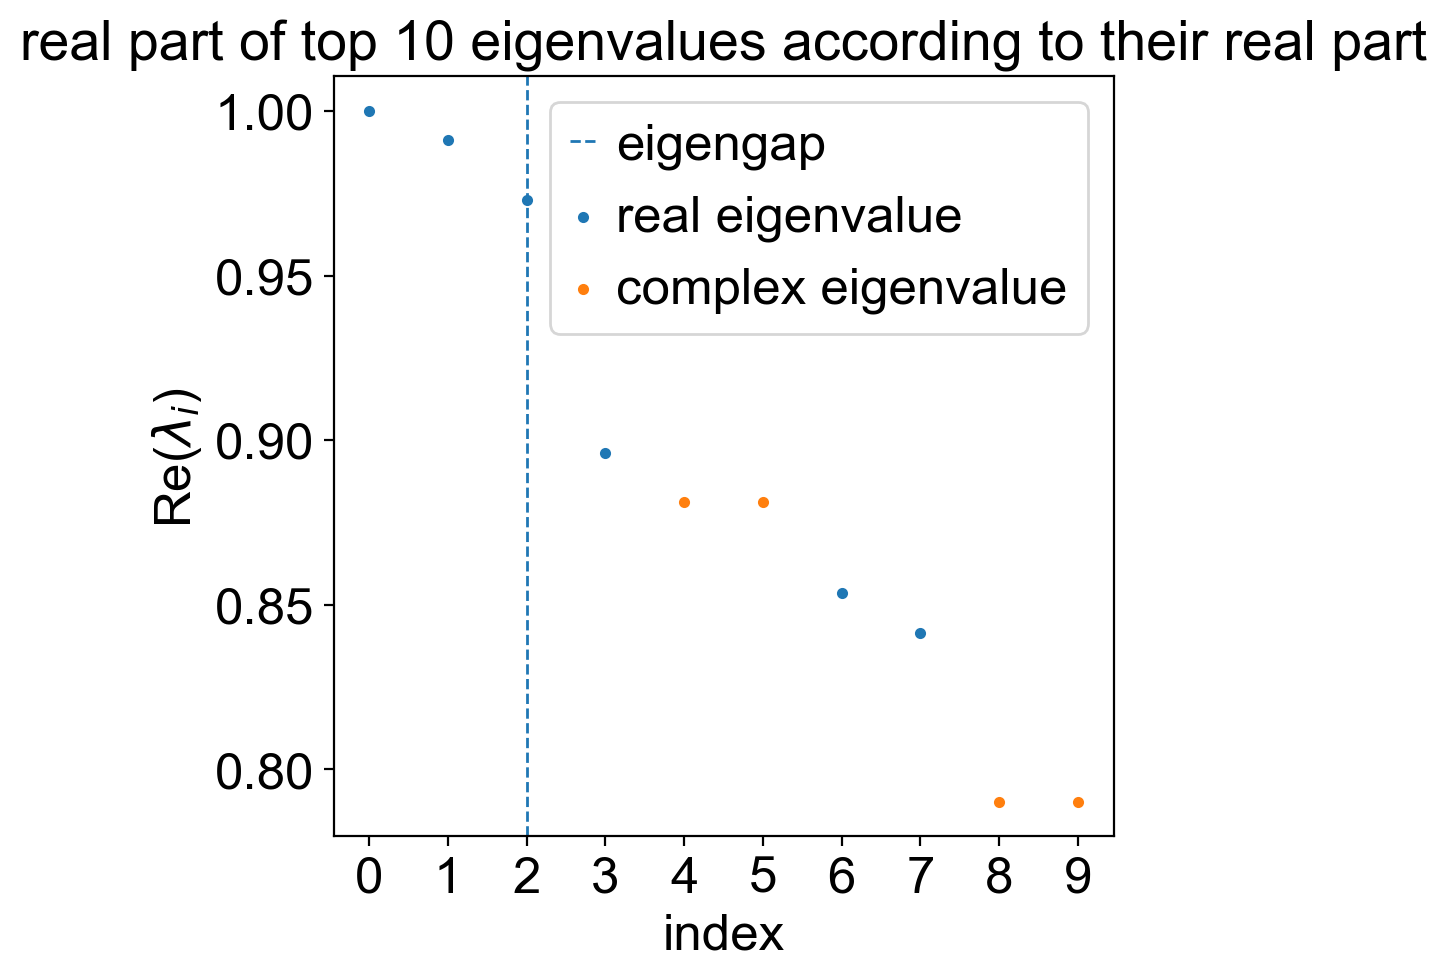

In [28]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True)